# Bitcoin Transaction Fraud Detection using Neo4j

## 1. Introduction 

This project demonstrates how to detect suspicious and fraudulent transactions in a financial network using **graph databases** and **graph analytics**. By modeling transactions as nodes and money transfers as relationships in Neo4j, we uncover hidden patterns — including fraud rings, circular money flows, and high-risk intermediaries — that traditional tabular analysis often misses.

We will:
- Build a graph in Neo4j from transaction data
- Explore fraud patterns via community detection, centrality, and circular flows
- Combine graph features with traditional ML for classification
- Present actionable insights useful for financial network security

**Tools**: Python, Neo4j, Pandas, NetworkX, Scikit-learn


#### Table of Contents
1. Project Overview
2. Setup & Configuration
3. Data Loading, Exploration, and Graph Modeling in Neo4j
4. Graph Analysis
   - Centrality Analysis
   - Community Detection
   - Fraud Flow (Cycle) Detection
   - Shortest Paths (if two frauds are connected within 3–5 steps)
5. Hybrid Graph + ML Approach
6. Results & Conclusions
7. Next Steps & Improvements

## 2. Setup & Configuration
We configure Python and Neo4j for graph analytics. Ensure you have:
- A running Neo4j instance
- Correct URI, username, and password


In [111]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Connect
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("userId", "password"))
print("Driver initialized successfully")


Driver initialized successfully


## 3. Data Loading & Exploration
We load the anonymized Bitcoin transaction graph. Each **node** is a transaction, each **edge** represents flow of bitcoins.

#### Dataset  

- **Input files**:
 1. `elliptic_txs_features.csv`: For each transaction (txId), there are 165+ numeric features that describe behaviors: amounts, frequency, network position, etc.
  2. `elliptic_txs_edgelist.csv`: Shows connections between transactions
  3. `elliptic_txs_classes.csv`: Labels each transaction as `LICIT`, `FRAUD`, or `UNKNOWN`. This provides the ground truth for fraud detection.


- **Source:** [Elliptic Data Set (Kaggle)](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data)  

---

#### Graph Schema  

- **Nodes:** `Transaction`
- **Relationship:**   `(Transaction)-TRANSFERRED_TO->(Transaction)` from `elliptic_txs_edgelist.csv`  

---



In [112]:
# Query
with driver.session() as session:
    # --- Create uniqueness constraints ---
    session.run("""
        CREATE CONSTRAINT txn_id_unique IF NOT EXISTS
        FOR (t:Transaction) REQUIRE t.ID IS UNIQUE
    """)
    
    print("✅ Constraint created successfully.")
    # --- Load Transactions, features, and edges from CSV ---
    session.run("""
        CALL(){
        LOAD CSV FROM 'https://www.dropbox.com/scl/fi/67es6o6ky9r67j7e7orae/elliptic_txs_features.csv?rlkey=0nk7zddwm4tzwk26nrij33uo9&st=l5p9iney&dl=1' AS row
        MERGE (t:Transaction {ID: row[0], time_step: toInteger(row[1])} ) 
        SET t.feature_1 = toFloat(row[2]),
        t.feature_2 = toFloat(row[3]),
        t.feature_3 = toFloat(row[4]),
        t.feature_4 = toFloat(row[5]),
        t.feature_5 = toFloat(row[6]),
        t.feature_6 = toFloat(row[7]),
        t.feature_7 = toFloat(row[8]),
        t.feature_8 = toFloat(row[9]),
        t.feature_9 = toFloat(row[10]),
        t.feature_10 = toFloat(row[11]),
        t.feature_11 = toFloat(row[12]),
        t.feature_12 = toFloat(row[13]),
        t.feature_13 = toFloat(row[14]),
        t.feature_14 = toFloat(row[15]),
        t.feature_15 = toFloat(row[16]),
        t.feature_16 = toFloat(row[17]),
        t.feature_17 = toFloat(row[18]),
        t.feature_18 = toFloat(row[19]),
        t.feature_19 = toFloat(row[20])
         } IN TRANSACTIONS OF 100 ROWS
    """)
    print("Transactions loaded.")


✅ Constraint created successfully.
Transactions loaded.


In [113]:
    # --- Load edges (elliptic_txs_edgelist.csv) into Neo4j ---
with driver.session() as session:
    session.run("""
        LOAD CSV WITH HEADERS FROM 'https://www.dropbox.com/scl/fi/36gzx7tiwhl5oel2593hs/elliptic_txs_edgelist.csv?rlkey=3gdoyawqw6mz8tgjf54nrr6s0&st=fzdm080b&dl=1' AS row
        MATCH (t1:Transaction{ID:row.txId1}), (t2:Transaction{ID:row.txId2})
        merge (t1)-[:TRANSFERRED_TO]->(t2)
        """)
    print("Edges loaded.")
    


Edges loaded.


In [114]:
    # --- Load labels (elliptic_txs_classes.csv)  by matching transactions and sets their class: FRAUD, LICIT, or UNKNOWN.
    with driver.session() as session:
        session.run("""
        LOAD CSV WITH HEADERS FROM 'https://www.dropbox.com/scl/fi/7fudzzv4h5lc9g4boo6bd/elliptic_txs_classes.csv?rlkey=d9zqmvxg9g9dr0kvnu7vzdbzd&st=aomm5idc&dl=1' AS row
        MATCH (t1:Transaction{ID:row.txId})
        SET t1.class = CASE row.class
            WHEN "1" THEN "FRAUD"
            WHEN "2" THEN "LICIT"
            ELSE "UNKNOWN"
            END;
        """)
    print("Labels loaded.")
    

Labels loaded.


### 3.1 Exploratory Queries

1. **Class Distribution** – Count how many transactions are labeled `LICIT`, `FRAUD`, and `UNKNOWN` to understand the overall data balance.  

In [115]:
 with driver.session() as session:
     record = session.run("""
        MATCH (t:Transaction{class:"FRAUD"})
        WITH count(t) as fraud_count
        MATCH (t:Transaction{class:"LICIT"})
        WITH fraud_count, count(t) as licit_count
        MATCH (t:Transaction{class:"UNKNOWN"})
        RETURN fraud_count, licit_count, count(t) as unknown_count
        """)
     rec = record.single()
     res = ["Fraud Count", "Licit Count", "Unknown Count"]
     j=0
     for i in rec:
         print(f'{res[j]}: {i}')
         j=j+1
     #print(rec)

Fraud Count: 4545
Licit Count: 42019
Unknown Count: 157205


2. **Degree Distribution** – Compute and visualize in-degree and out-degree across all transactions to uncover typical connectivity patterns and detect structural anomalies.  


In [116]:
#Add in-degree and out-degree of each node as a feature
with driver.session() as session:
    record = session.run("""
    MATCH (t:Transaction)
    SET t.out_degree = size([(t)-[:TRANSFERRED_TO]->() | 1]),
    t.in_degree  = size([()-[:TRANSFERRED_TO]->(t) | 1])
    """)


In [117]:
with driver.session() as session:
    result = session.run("""
    MATCH (t:Transaction)
    RETURN t.ID AS ID, t.out_degree AS outDeg, t.in_degree as inDeg
    """)
    degrees = [rec.data() for rec in result]
    df_degrees = pd.DataFrame(degrees)
    
df_degrees.head()
    

,ID,outDeg,inDeg
0,246066701,1,0
1,246026779,2,1
2,139221353,2,1
3,139417998,2,0
4,42264430,0,1


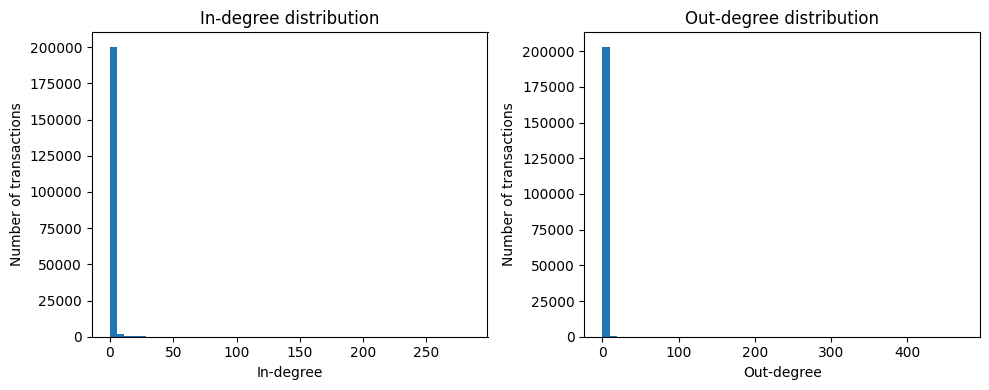

In [118]:

plt.figure(figsize=(10,4))

# In-degree distribution
plt.subplot(1,2,1)
plt.hist(df_degrees['inDeg'], bins=50)
plt.title("In-degree distribution")
plt.xlabel("In-degree")
plt.ylabel("Number of transactions")

# Out-degree distribution
plt.subplot(1,2,2)
plt.hist(df_degrees['outDeg'], bins=50)
plt.title("Out-degree distribution")
plt.xlabel("Out-degree")
plt.ylabel("Number of transactions")

plt.tight_layout()
plt.show()


3. **High-Degree Nodes (Hubs)** – Identify the most highly connected transactions (both incoming and outgoing) that may represent exchanges, mixers, or fraud “hot spots.”  

In [119]:
#Print 20 nodes with highest out-degree
with driver.session() as session:
    record = session.run("""
        MATCH (t:Transaction)
        RETURN t.ID AS transaction_id,
               t.out_degree AS out_degree,
               t.in_degree AS in_degree
               order by out_degree desc limit 20
            """)
    #res = record.single()
    for ind in record:
        print(ind["transaction_id"],ind["out_degree"], ind["in_degree"])
    

2984918 472 1
89273 288 1
102570 122 0
3181 112 1
7952 99 1
1891081 95 0
143705 92 0
565334 90 1
488266 88 1
793584 82 1
4600600 76 0
792948 74 1
3185686 72 0
1192279 69 0
5678249 67 0
36460504 65 1
847323 64 0
520060 62 1
65253 53 0
3180883 51 0


4. ***Check Whether Highly Connected Nodes Are Associated with Fraud*** - Highly connected nodes (high degree) may represent key intermediaries in the transaction network (e.g., exchanges, mixers, mule accounts).  By analyzing the in-degree and out-degree of the most connected transactions, we can see whether fraudulent behavior tends to cluster in such hubs.

In this step, we:
- Retrieve the top *N* nodes by **out-degree** and **in-degree**.
- Count how many of these nodes are labeled as `FRAUD`.
- Use this as an initial signal of whether highly connected transactions are disproportionately fraudulent.


In [120]:
#to see how many high degree nodes are labelled with `FRAUD` 
with driver.session() as session:
    result = session.run("""
    match  (t:Transaction)
        return t.ID as ID, t.out_degree as out, t.class as label order BY t.out_degree desc LIMIT 500
        
        """)
    count_out = 0
    #print("High Out Degree\n")
    for record in result:
        #print(record["ID"],record["out"],record["label"])
        if record["label"]=="FRAUD":
            count_out=count_out+1
    #print(f'\n There are {count_out} FRAUD nodes in 100 high out-degree nodes \n')
    print(f"\nFraudulent nodes in top 500 OUT-degree: {count_out} "
          f"({count_out/500:.1%})\n")

    result = session.run("""
    match (t:Transaction)
        return t.ID as ID, t.in_degree as in, t.class as label order BY t.in_degree desc LIMIT 500
        
        """)
    count_in = 0
    #print("\n High IN Degree\n")
    for record in result:
        #print(record["ID"],record["in"],record["label"])
        if record["label"]=="FRAUD":
            count_in=count_in+1
    #print(f'\n There are {count_in} FRAUD nodes in 100 in-degree nodes \n')
    print(f"\nFraudulent nodes in top 500 IN-degree: {count_in} "
          f"({count_in/500:.1%})\n")






Fraudulent nodes in top 500 OUT-degree: 0 (0.0%)


Fraudulent nodes in top 500 IN-degree: 24 (4.8%)



***Visualize Fraud Distribution Among Highly Connected Nodes*** - To better showcase this analysis, we visualize the in-degree and out-degree distribution of the top connected transactions, highlighting which ones are labeled as fraudulent.

This makes it easier to:
- Spot whether fraud tends to appear in hubs.
- Communicate findings visually (important for non-technical stakeholders and recruiters).


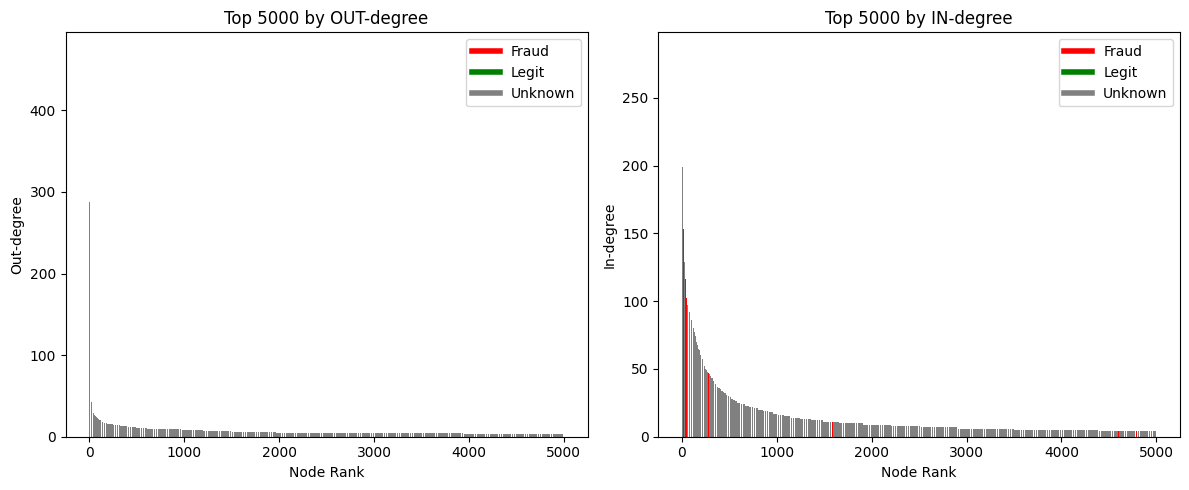

In [121]:
# Collect results into DataFrames for plotting
out_data = []
in_data = []

with driver.session() as session:
    # Out-degree query
    out_query = f"""
    MATCH (t:Transaction)
    RETURN t.ID AS ID, t.out_degree AS degree, t.class AS label
    ORDER BY t.out_degree DESC
    LIMIT 5000
    """
    for record in session.run(out_query):
        out_data.append({"ID": record["ID"], "Degree": record["degree"], "Label": record["label"]})

    # In-degree query
    in_query = f"""
    MATCH (t:Transaction)
    RETURN t.ID AS ID, t.in_degree AS degree, t.class AS label
    ORDER BY t.in_degree DESC
    LIMIT 5000
    """
    for record in session.run(in_query):
        in_data.append({"ID": record["ID"], "Degree": record["degree"], "Label": record["label"]})

# Convert to DataFrame
out_df = pd.DataFrame(out_data)
in_df = pd.DataFrame(in_data)
# Map labels to colors, safely fill in missing
def label_to_color(label):
    if label == "FRAUD":
        return "red"
    elif label == "LEGIT":
        return "green"
    else:
        return "gray"   # unknown or None

# Apply color mapping
out_df["Color"] = out_df["Label"].apply(label_to_color)
in_df["Color"] = in_df["Label"].apply(label_to_color)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Out-degree plot
axes[0].bar(out_df.index, out_df["Degree"], color=out_df["Color"])
axes[0].set_title(f"Top 5000 by OUT-degree")
axes[0].set_xlabel("Node Rank")
axes[0].set_ylabel("Out-degree")
axes[0].legend(handles=[
    plt.Line2D([0], [0], color="red", lw=4, label="Fraud"),
    plt.Line2D([0], [0], color="green", lw=4, label="Legit"),
    plt.Line2D([0], [0], color="gray", lw=4, label="Unknown")
])

# In-degree plot
axes[1].bar(in_df.index, in_df["Degree"], color=in_df["Color"])
axes[1].set_title(f"Top 5000 by IN-degree")
axes[1].set_xlabel("Node Rank")
axes[1].set_ylabel("In-degree")
axes[1].legend(handles=[
    plt.Line2D([0], [0], color="red", lw=4, label="Fraud"),
    plt.Line2D([0], [0], color="green", lw=4, label="Legit"),
    plt.Line2D([0], [0], color="gray", lw=4, label="Unknown")
])

plt.tight_layout()
plt.show()


### 4. Centrality Analysis (PageRank, Betweenness)
Identifies highly connected or influential transactions that may act as intermediaries in fraud flows.


In [122]:
#Highly influencial transactions using Pagerank
with driver.session() as session:
    session.run("CALL gds.graph.drop('myGraph', false) YIELD graphName RETURN graphName")
    session.run("""
        CALL gds.graph.project('myGraph', 'Transaction', {TRANSFERRED_TO: {orientation: 'UNDIRECTED'}})
        """)
    session.run("""
            CALL gds.pageRank.write('myGraph', {writeProperty: 'pagerank'})
            """)
    
    result = session.run("""
        match (t:Transaction)
        RETURN t.ID AS txn, t.pagerank as score
        ORDER BY score DESC LIMIT 10;
        """)
    for record in result:
        print(f"{record['txn']:<30} {record['score']:.4f}")

2984918                        141.4859
89273                          91.2354
96576418                       87.2416
30699343                       79.7543
43388675                       72.2568
234890810                      72.0152
196107869                      71.0314
225859042                      68.9972
225711361                      64.2240
269905668                      63.4981


In [123]:
with driver.session() as session:
    result = session.run("""CALL gds.degree.stats('myGraph')
        YIELD centralityDistribution,
              preProcessingMillis,
              computeMillis,
              postProcessingMillis,
              configuration
        RETURN centralityDistribution as txn, computeMillis as score
        """)
    for record in result:
        print("Txn Distribution:", record["txn"])
        print("Compute Time (ms):", record["score"])
        print()

   

Txn Distribution: {'min': 1.0, 'max': 473.00195312499994, 'p90': 3.0000076293945312, 'p999': 64.00048065185547, 'p99': 13.000053405761719, 'p50': 2.0000076293945312, 'p75': 2.0000076293945312, 'p95': 4.000022888183594, 'mean': 2.300209062895285}
Compute Time (ms): 1



In [124]:
#Centrality (Betweenness) → key intermediaries in fraud flow.

with driver.session() as session:
    result = session.run("""CALL gds.betweenness.stream('myGraph')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).ID AS txn, score
        ORDER BY score DESC LIMIT 50;
        """)
    #for record in result:
     #   print(f"{record['txn']:<30} {record['score']:.4f}")
    data = [(record["txn"], record["score"]) for record in result]
    df = pd.DataFrame(data, columns=["Transaction", "BetweennessScore"])
    display(df)

,Transaction,BetweennessScore
0,89273,1.505942e+07
1,225859042,1.158780e+07
2,2984918,9.768645e+06
3,232438397,9.209297e+06
4,43388675,6.225191e+06
5,245424768,5.228985e+06
6,2758467,5.102536e+06
7,68705820,4.924920e+06
8,2881273,4.846830e+06
9,245440872,4.522831e+06



### 4.2 Fraud Flow (Cycle) Detection
Finds circular transaction patterns often used to hide money movement.


In [125]:
#to detect cycles for fraud transactions
with driver.session() as session:
    result = session.run("""
    match p= (t:Transaction{ID:"2984918"})-[:TRANSFERRED_TO*2..10]-(t)
        return [n IN nodes(p) | n.ID] AS cyclePath
        LIMIT 50
        """)
    for record in result:
        print(record["cyclePath"])
    

['2984918', '372878326', '321465316', '317001228', '2984918']
['2984918', '372878326', '321465316', '317001228', '2984918', '372739354', '306822977', '2984918']
['2984918', '372878326', '321465316', '317001228', '2984918', '372739354', '306822977', '2984918', '311016758', '372956178', '2984918']
['2984918', '372878326', '321465316', '317001228', '2984918', '372739354', '306822977', '2984918', '372956178', '311016758', '2984918']
['2984918', '372878326', '321465316', '317001228', '2984918', '372739354', '306822977', '2984918', '372721608', '323477650', '2984918']
['2984918', '372878326', '321465316', '317001228', '2984918', '372739354', '306822977', '2984918', '372681524', '318146616', '2984918']
['2984918', '372878326', '321465316', '317001228', '2984918', '372739354', '306822977', '2984918', '372878747', '372823086', '2984918']
['2984918', '372878326', '321465316', '317001228', '2984918', '372739354', '306822977', '2984918', '373154032', '372979919', '2984918']
['2984918', '372878326'

### 4.3 Shortest Path detection
Use shortest path analysis to see whether two fraudulent transactions are linked within 3–5 hops in the network.

In [126]:
#Shortest paths → check if two frauds are connected within 3–5 steps
with driver.session() as session:
    result = session.run("""
    MATCH p = (t:Transaction{class:"FRAUD"})-[:TRANSFERRED_TO*3..5]->(t1:Transaction{class:"FRAUD"})
        return [n IN nodes(p)| n.ID] as shortest_path
    """)
    for record in result:
        print(record["shortest_path"])
    
    #NEXT STEP: CHECK EACH OF THE INTERMEDIATE TRANSACTIONS ARE ALSO FRAUD OR NOT

['163862205', '168158009', '166492424', '168158015']
['163862205', '168158009', '166492424', '168158015', '55300089']
['163862205', '168158009', '166492424', '168158015', '55300089', '163657206']
['168158009', '166492424', '168158015', '55300089']
['168158009', '166492424', '168158015', '55300089', '163657206']
['168158009', '166492424', '168158015', '55300089', '163657206', '163657331']
['166072787', '166072790', '56397284', '166072794']
['166072787', '166072790', '56397284', '166072794', '166073482']
['166072787', '166072790', '56397284', '166072794', '166073482', '166073487']
['166071318', '166071322', '166071329', '166071333']
['166071318', '166071322', '166071329', '166071333', '166071612']
['166071318', '166071322', '166071329', '166071333', '166071612', '166071629']
['166071322', '166071329', '166071333', '166071612']
['166071322', '166071329', '166071333', '166071612', '166071629']
['166071322', '166071329', '166071333', '166071612', '166071629', '166072474']
['163662273', '163

### 4.4 Community Detection (`Louvain algorithm` and `Label Propagation`)
Groups transactions into communities and identifies clusters with disproportionately high illicit activity.


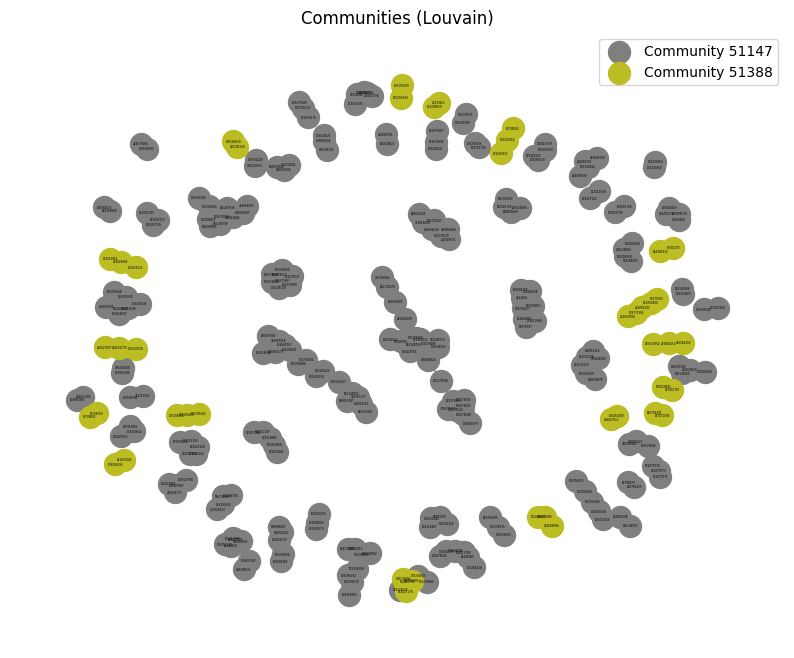

In [127]:
#Louvain Algo
with driver.session() as session:
    session.run("""CALL gds.louvain.write('myGraph', {writeProperty: 'community'})""")

    result = session.run("""
        match(t:Transaction)
        RETURN t.ID AS txId, t.community as com_ID
            """)

     #for record in result:
     #   print(f"{record['com_ID']:<30} {record['communitySize']:.4f}")
    communities = {}
    for record in result:
        txId = record["txId"]
        comm = record["com_ID"]
        communities[txId] = comm
        # Add node with community color
        #net.add_node(txId, label=str(txId), group=comm)

    # Now add edges between transactions
    edge_query = """
    MATCH (a:Transaction)-[:TRANSFERRED_TO]->(b:Transaction)
    RETURN a.ID AS src, b.ID AS dst
    LIMIT 200
    """
    edges = [(record["src"], record["dst"]) for record in session.run(edge_query)]
    # Build networkx graph
    G = nx.Graph()
    G.add_edges_from(edges)

    node2comm = {node: communities.get(node, -1) for node in G.nodes()}

    # Pick a layout (spring layout for clarity)
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes with community colors
    plt.figure(figsize=(10, 8))
    for comm_id in set(node2comm.values()):
        nodes_in_comm = [n for n in G.nodes() if node2comm[n] == comm_id]
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=nodes_in_comm,
            node_size=250,
            node_color=[plt.cm.tab10(comm_id % 10)], # cycle colors
            label=f"Community {comm_id}"
            )

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=2)

    plt.legend()
    plt.title("Communities (Louvain)")
    plt.axis("off")
    plt.show()


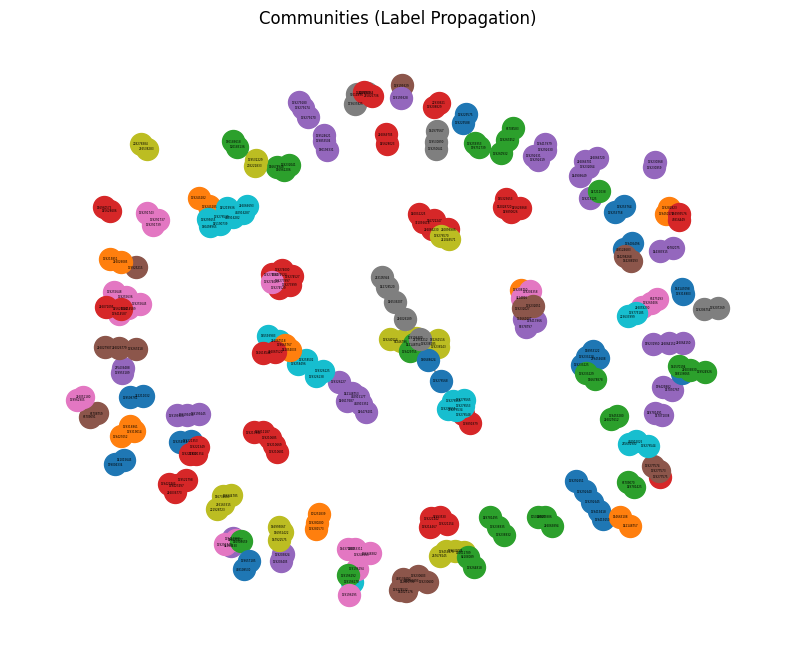

In [128]:
from pyvis.network import Network

# Initialize Pyvis network
#net = Network(notebook=True, directed=True, height="750px", width="100%")


#Label Propagation Algo
with driver.session() as session:
    result = session.run("""
    CALL gds.labelPropagation.stream('myGraph')
        YIELD nodeId, communityId
        RETURN gds.util.asNode(nodeId).ID as txId, communityId AS com_ID
            """)
   
    #for record in result:
     #   print(f"{record['com_ID']:<30} {record['communitySize']:.4f}")

    #result = session.run(query)

    communities = {}
    for record in result:
        txId = record["txId"]
        comm = record["com_ID"]
        communities[txId] = comm
        # Add node with community color
        #net.add_node(txId, label=str(txId), group=comm)

    # Now add edges between transactions
    edge_query = """
    MATCH (a:Transaction)-[:TRANSFERRED_TO]->(b:Transaction)
    RETURN a.ID AS src, b.ID AS dst
    LIMIT 200
    """
    edges = [(record["src"], record["dst"]) for record in session.run(edge_query)]
    # Build networkx graph
    G = nx.Graph()
    G.add_edges_from(edges)

    node2comm = {node: communities.get(node, -1) for node in G.nodes()}
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes with community colors
    plt.figure(figsize=(10, 8))
    for comm_id in set(node2comm.values()):
        nodes_in_comm = [n for n in G.nodes() if node2comm[n] == comm_id]
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=nodes_in_comm,
            node_size=250,
            node_color=[plt.cm.tab10(comm_id % 10)], # cycle colors
            label=f"Community {comm_id}"
            )

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=2)

    #plt.legend()
    plt.title("Communities (Label Propagation)")
    plt.axis("off")
    plt.show()


In [129]:
# Visualize a sample of 100 transaction relationships as an interactive network (PyVis).
from pyvis.network import Network

# create a network
net = Network(notebook=True, height="500px", width="100%", bgcolor="#222222", font_color="white")
with driver.session() as session:
    query = ("""
        MATCH (t:Transaction)-[:TRANSFERRED_TO]->(t1:Transaction)
        return t.ID as src,t1.ID as dst LIMIT 100
        """)
    result = session.run(query)

    for record in result:
        src, dst = record["src"], record["dst"]
        net.add_node(src, label=str(src), color="orange")
        net.add_node(dst, label=str(dst), color="blue")
        net.add_edge(src, dst)

# Show in notebook
net.show("transactions.html")

transactions.html


###  4.5 Machine Learning Fraud Classification

In this section, we train a simple supervised learning model to predict whether a transaction is **fraudulent** or **licit** based on the features we extracted from the graph.

We will:

1. **Extract labeled transactions** (`FRAUD`, `LICIT`) from Neo4j along with graph features.
2. **Prepare a feature matrix** (`X`) and target vector (`y`).
3. **Train a Random Forest classifier**.
4. **Evaluate the model** using accuracy, precision, recall, and F1-score.
5. **Inspect feature importance** to see which graph features are most predictive of fraud.


In [130]:
# 1. Extract labeled transactions with features from Neo4j

with driver.session() as session:
    query = """
    MATCH (t:Transaction)
    WHERE t.class IN ['FRAUD', 'LICIT']
    RETURN
        t.ID AS ID,
        t.class AS label,
        t.in_degree AS in_degree,
        t.out_degree AS out_degree,
        t.pagerank AS pagerank,
        t.community AS community
    """
    result = session.run(query)
    data = [record.data() for record in result]

df = pd.DataFrame(data)

# Encode labels: FRAUD = 1, LICIT = 0
df['label'] = df['label'].map({'FRAUD': 1, 'LICIT': 0})

# One-hot encode community if needed
df = pd.get_dummies(df, columns=['community'], drop_first=True)

# Define X (features) and y (target)
X = df.drop(columns=['ID', 'label'])
y = df['label']


In [131]:
# 2. Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [132]:
# 3. Train a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [133]:
# 4. Evaluate the model
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.96      0.95      8404
           1       0.58      0.57      0.58       909

    accuracy                           0.92      9313
   macro avg       0.77      0.76      0.77      9313
weighted avg       0.92      0.92      0.92      9313



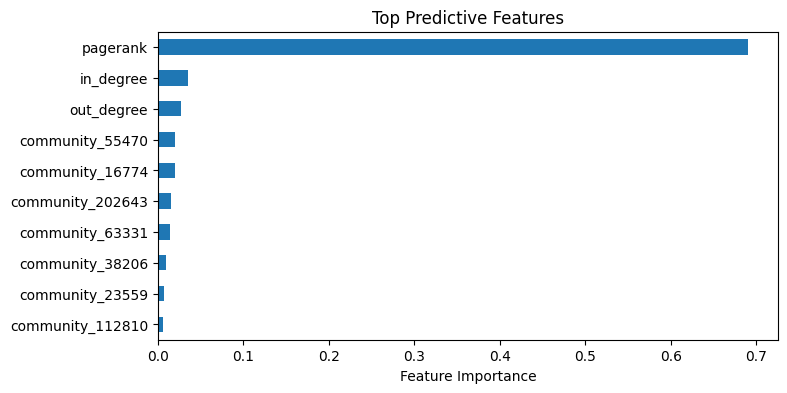

In [134]:
# 5. Inspect feature importance

importances = pd.Series(clf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

plt.figure(figsize=(8, 4))
importances_sorted.head(10).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Top Predictive Features')
plt.gca().invert_yaxis()
plt.show()


***Observations***

- The model provides an initial indication of which graph-based features (like **in-degree**, **out-degree**, **PageRank**, or **community membership**) are correlated with fraudulent behavior.
- Even a simple Random Forest can achieve reasonable recall, which is critical for fraud detection.
- This hybrid approach demonstrates how **graph analytics** and **machine learning** can complement each other in detecting suspicious patterns.


## 5. Conclusions

1. **Data successfully modeled as a graph**  
   Bitcoin transactions were ingested into Neo4j as a property graph. Each transaction is represented as a node, and each transfer between transactions is modeled as a `TRANSFERRED_TO` relationship.

2. **Fraud patterns identified**  
   - Nodes labeled as `FRAUD` were found and analyzed for connectivity.  
   - Centrality metrics (degree, PageRank, betweenness) highlighted highly connected nodes that may act as intermediaries in money flow.  
   - Community detection algorithms (Louvain, Label Propagation) revealed clusters containing multiple `FRAUD` transactions — indicating potential fraud rings.

3. **Circular flows and money laundering risk**  
   Detection of cycles within the graph uncovered circular transaction paths, often used to conceal money movement. These loops can point to layering activities commonly associated with money laundering.

4. **High-degree hubs**  
   Analysis of in-degree and out-degree distributions surfaced hub nodes (transactions interacting with many others). A small fraction of these hubs were flagged as `FRAUD`, making them important targets for deeper investigation.

5. **Interactive visualization**  
   Selected subgraphs were visualized using PyVis to provide an interactive view of transaction paths, fraud communities, and suspicious linkages. This makes patterns and anomalies accessible to non-technical stakeholders.

6. **Practical application**  
   The approach demonstrates how graph analytics can uncover hidden relationships in financial networks that traditional tabular analysis might miss — providing a strong foundation for real-world anti-money-laundering (AML) systems.

7.  **Hybrid Graph + ML Models**  
   Combine graph features (centrality, community membership, cycle counts) with machine learning models to improve fraud classification accuracy.

---

## 6. Future Work


1. **Temporal Analysis**  
   Incorporate time steps to detect evolving fraud rings and sudden changes in transaction behavior over time.

2. **Risk Scoring System**  
   Develop a scoring mechanism to rank transactions by risk level, prioritizing investigation efforts.

3. **Real-time Stream Processing**  
   Adapt the pipeline to handle live blockchain data, enabling proactive fraud detection instead of retrospective analysis.

4. **Scalability & Optimization**  
   Evaluate performance on larger graphs and optimize Cypher queries, indexing strategies, and memory management for production re


In [135]:
driver.close()